In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
import math

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




In [3]:
data = pd.read_csv('../output_columns/total.csv')
data['date'] = pd.to_datetime(data['date'])
data.head()


print(data['energy_production'].describe())

count       786.000000
mean     174974.273537
std       52466.894687
min       11602.000000
25%      140161.250000
50%      184586.500000
75%      216029.000000
max      270014.000000
Name: energy_production, dtype: float64


In [4]:
import numpy as np

# Generate related data
np.random.seed(42)  # For reproducibility

# Assuming energy_production is in kWh, we can create related data as follows:
# Humidity (in %) - inversely related to energy production
data['humidity'] = 100 - (data['energy_production'] / data['energy_production'].max() * 50) + np.random.normal(0, 5, len(data))

# Solar Irradiance (in W/m^2) - directly related to energy production
data['solar_irradiance'] = (data['energy_production'] / data['energy_production'].max() * 1000) + np.random.normal(0, 50, len(data))

# Temperature (in °C) - somewhat related to energy production
data['temperature'] = (data['energy_production'] / data['energy_production'].max() * 30) + np.random.normal(0, 2, len(data))

# Ensure values are within realistic ranges
data['humidity'] = data['humidity'].clip(0, 100)
data['solar_irradiance'] = data['solar_irradiance'].clip(0, 1200)
data['temperature'] = data['temperature'].clip(-10, 50)

# Write the manipulated data to a CSV file
data.to_csv('man2122.csv', index=False)

# Display the first few rows of the new dataframe
data.head()

,date,energy_production,humidity,solar_irradiance,temperature
0,2021-01-01,148961,74.899631,593.374910,17.137480
1,2021-01-02,142961,72.835792,552.416736,13.170568
2,2021-01-03,153821,74.754549,566.169583,18.023196
3,2021-01-04,152869,79.307543,483.104079,16.913281
4,2021-01-05,153901,70.330526,591.455060,13.868961


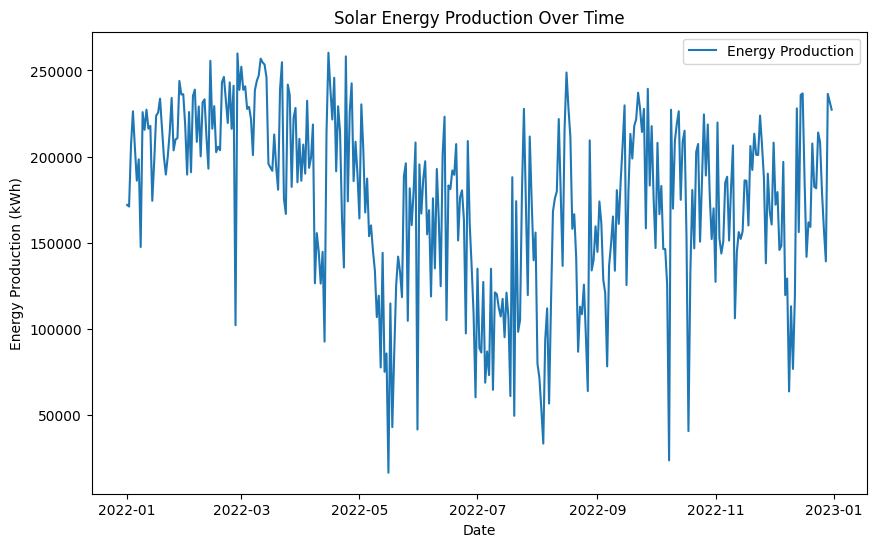

In [141]:
# Plot the solar energy production over time
plt.figure(figsize=(10,6))
plt.plot(data['date'], data['energy_production'], label='Energy Production')
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Solar Energy Production Over Time')
plt.legend()
plt.show()

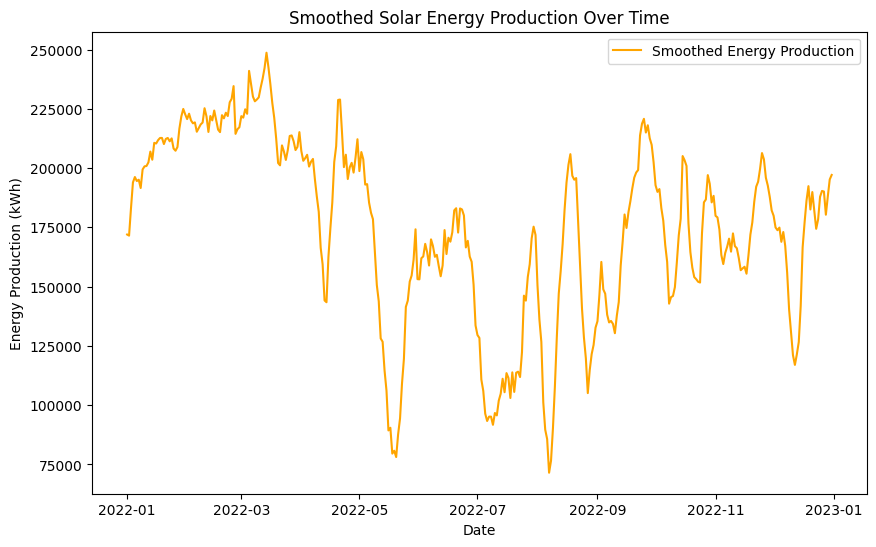

,date,energy_production
0,2022-01-01,171965.000000
1,2022-01-02,171495.500000
2,2022-01-03,183128.000000
3,2022-01-04,193922.750000
4,2022-01-05,196215.200000
5,2022-01-06,194521.500000
6,2022-01-07,195080.857143
7,2022-01-08,191591.000000
8,2022-01-09,199416.000000
9,2022-01-10,200725.571429


In [142]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Apply a rolling mean to smooth the data with min_periods to avoid NaN values
# data['energy_production'] = data['energy_production'].ewm(span=7, adjust=False).mean()
# Apply LOESS smoothing
# loess_smoothed = lowess(data['energy_production'], data['date'], frac=0.1)
# data['energy_production'] = loess_smoothed[:, 1]

# Apply a moving average to smooth the data
data['energy_production'] = data['energy_production'].rolling(window=7, min_periods=1).mean()

# Plot the smoothed solar energy production over time
plt.figure(figsize=(10,6))
plt.plot(data['date'], data['energy_production'], label='Smoothed Energy Production', color='orange')
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Smoothed Solar Energy Production Over Time')
plt.legend()
plt.show()

data.head(32)

In [143]:
# Partition the data into train_data and test_data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

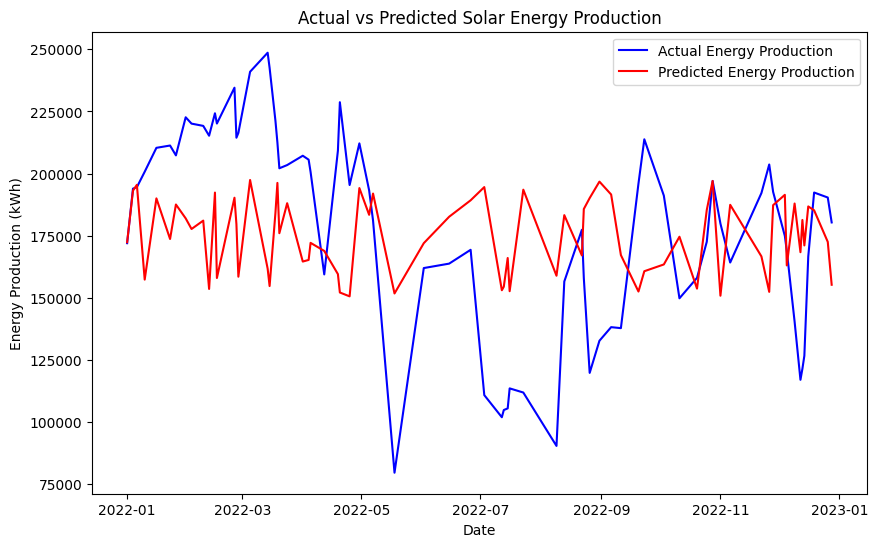

In [144]:
# Convert 'date' to ordinal numbers for regression
train_data['date_ordinal'] = pd.to_datetime(train_data['date']).map(datetime.toordinal)
test_data['date_ordinal'] = pd.to_datetime(test_data['date']).map(datetime.toordinal)

# Split target (y) and feature (X) for both train and test sets
y_train = train_data['energy_production']
X_train = train_data[['date_ordinal']]

y_test = test_data['energy_production']
X_test = test_data[['date_ordinal']]

# Define and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
predicted_values = linear_model.predict(X_test)

# Sort the test data by date for continuous plotting
sorted_test_data = test_data.sort_values(by='date')
sorted_predicted_values = predicted_values[sorted_test_data.index.argsort()]

# Plot actual vs predicted energy production with correct date formatting
plt.figure(figsize=(10,6))
plt.plot(sorted_test_data['date'], sorted_test_data['energy_production'], label='Actual Energy Production', color='blue')
plt.plot(sorted_test_data['date'], sorted_predicted_values, label='Predicted Energy Production', color='red')
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Actual vs Predicted Solar Energy Production')
plt.legend()
plt.show()


In [145]:
# Calculate RMSE (Root Mean Squared Error)
rmse = math.sqrt(mean_squared_error(y_test, predicted_values))
print(f'RMSE: {rmse}')

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, predicted_values)
print(f'MAE: {mae}')

# Calculate R² score
r2 = r2_score(y_test, predicted_values)
print(f'R² Score: {r2}')

RMSE: 35742.87173537362
MAE: 29680.642656591477
R² Score: 0.21645424402336955
